In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [89]:
#utility functions
def make_homo(X):
    #[x,y...]->[w,y,....,1]
    return np.hstack((X,np.ones((X.shape[0],1))))

def make_norm_mat(means,std):
    diags = np.sqrt(len(means))*np.diag(1/std)
    col = np.array(-means/std).reshape(-1,1)
    F = np.hstack((np.vstack((diags,np.zeros((1,diags.shape[1]))))\
                ,np.vstack((col,np.array([1])))))
    return F

# Image Registration
In this section we map 3D World cordinate to 2D image cordinates. 

## 3D World frame
This Axis used for 3D system is as follows:<br>
![3d image axis](data/3d.png)

## 2D Image frame
This image axis mapped in 2D image is as follows: <br>
![2d image axis](data/2d.png)

## Mapping 3D -> to 2D
We select random points in 3D world frame and map corresponding points in 2D image using pixel locations of those points in 2D image. 

In [90]:
points_3d = np.array([[100,0,0],
         [75,0,25],
         [0,25,50],
         [0,75,75],
         [0,50,100],
         [25,0,175]])
        
points_2d = np.array([[135,137],
         [159,169],
         [283,191],
         [359,253],
         [323,296],
         [209,442]])

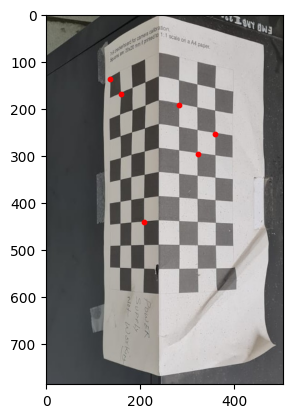

In [91]:
img = mpimg.imread('data/img.jpeg')
  
# Output Images
plt.imshow(img)
for i in range(points_2d.shape[0]):
    plt.scatter(points_2d[i][0], points_2d[i][1], s=10,c='red')
plt.show()

# Points Normalization
Normalize the data such that the centroid of 2D and 3D points are at origin and the
average Euclidean distance of 2D and 3D points from the origin is $\sqrt{2}$ and $\sqrt{3}$,
respectively. Find the transformation matrices $T$ and $U$ that achieve this for 2D and 3D
respectively, i.e, $\hat x = Tx$ and $\hat X = UX$ where $x$ and $X$ are the unnormalized 2D and 3D
points in homogeneous coordinates.

## 2D Normalization
As you can see the matrix has std deviation on the diagonal and mean shift in the last column.<br>
This is similar to Scaling(For $\sqrt{2}$ euclidean distance) and translation (for $(0,0)$ as the shifted centroid)<br>
The Translation matrix $T$ is created as follows
$$T = \begin{bmatrix} \sqrt{2}\over\sigma_x & 0 & -\mu_x\over\sigma_x \\ 
                      0 & \sqrt{2}\over\sigma_y & -\mu_y\over\sigma_y  \\
                      0 & 0 & 1\end{bmatrix}$$
                      
The new normalized points are given by application of this transformation matrix
$$\hat x = Tx$$

In [92]:
T = make_norm_mat(np.mean(points_2d, axis=0),np.std(points_2d,axis=0))
points_2d_norm_homo = np.matmul(T,make_homo(points_2d).T).T
points_2d_norm = points_2d_norm_homo[:,:2]
print('T :\n')
print(T)

print('\n\n After Normalization:\n')
print(points_2d_norm)

T :

[[ 0.01704257  0.         -2.94845701]
 [ 0.          0.01393737 -2.44409124]
 [ 0.          0.          1.        ]]


 After Normalization:

[[-0.64771056 -0.53467198]
 [-0.23868897 -0.08867624]
 [ 1.87458926  0.21794583]
 [ 3.1698243   1.08206257]
 [ 2.55629191  1.68136935]
 [ 0.61343935  3.7162249 ]]
[1.41421356 1.41421356]


## 3D Normalization

In [93]:
U = make_norm_mat(np.mean(points_3d, axis=0), np.std(points_3d,axis=0))
        
points_3d_norm_homo = np.matmul(U,make_homo(points_3d).T).T
points_3d_norm = points_3d_norm_homo[:,:3]


print('U :\n')
print(U)

print('\n\n After Normalization: \n')
print(points_3d_norm)

U :

[[ 0.04333891  0.          0.         -0.83405766]
 [ 0.          0.06        0.         -0.8660254 ]
 [ 0.          0.          0.0305623  -1.24986486]
 [ 0.          0.          0.          1.        ]]


 After Normalization: 

[[ 3.49983305 -0.8660254  -1.24986486]
 [ 2.41636038 -0.8660254  -0.48580741]
 [-0.83405766  0.6339746   0.27825004]
 [-0.83405766  3.6339746   1.04230749]
 [-0.83405766  2.1339746   1.80636493]
 [ 0.24941502 -0.8660254   4.09853728]]
[1.73205081 1.73205081 1.73205081]


# Estimation of projection matrix $P$

* Estimate the normalized projection matrix $\hat P$ using the DLT method. 
* Denormalize the projection matrix $\hat P. (P = T^{-1}\hat PU)$.

## The pattern Matrix
As mentioned in forsyth and ponce, The patter matrix _P_ is calculated as follows:<br>
_P_ = $\begin{bmatrix}
\bf P_{1}^T & \bf 0^T & -x_{1}\bf P_{1}^T\\
\bf 0^T & \bf P_{1}^T & -y_{1}\bf P_{1}^T\\
... & ... & ...\\
\bf P_{n}^T & \bf 0^T & -x_{n}\bf P_{n}^T\\
\bf 0^T & \bf P_{n}^T & -y_{n}\bf P_{n}^T
\end{bmatrix}$

In [61]:
P_1 = np.hstack((points_3d_norm_homo,np.zeros_like(points_3d_norm_homo),-points_2d_norm[:,0][:,np.newaxis]*points_3d_norm_homo))
P_2 = np.hstack((np.zeros_like(points_3d_norm_homo),points_3d_norm_homo,-points_2d_norm[:,1][:,np.newaxis]*points_3d_norm_homo))
P = np.zeros((P_1.shape[0]*2,P_1.shape[1]))
P[0::2,:] = P_1
P[1::2,:] = P_2

## SVD

In [62]:
u,w = np.linalg.eig(np.matmul(P.T,P))
P_norm = w[:,np.argmin(u)].reshape(3,4)
print(f'Normalized Projection Matrix:\n {P_norm}')


Normalized Projection Matrix:
 [[-0.35818117  0.31367582 -0.00641287 -0.03032855]
 [ 0.07354809  0.04534868  0.63027649 -0.03338529]
 [ 0.03329362  0.00681421 -0.01735114  0.60420855]]


## Denormalizing the projection matrix

In [63]:
P_unorm = np.matmul(np.linalg.inv(T),(np.matmul(P_norm,U)))
print(f'Denormalized Projection Matrix:\n {P_unorm}')

Denormalized Projection Matrix:
 [[-5.39880932e-01  9.59432282e-01 -8.42978445e-02  1.45294313e+02]
 [ 3.93333715e-01  2.17941144e-01  1.05254334e+00  5.33413369e+01]
 [ 8.33064059e-04  2.36051253e-04 -3.06163549e-04  5.92225054e-01]]


## Decomposing Projection matrix into $K$,$R$ and $t$
Decompose the projection matrix _P_$ = K\begin{bmatrix} R & | & -RX_o \end{bmatrix}$ into intrinsic matrix K, rotation matrix $R$ and the camera center $X_o$. $K$ and $R$ can be estimated using $RQ$ decomposition.

In [64]:
M = P_unorm[:3,:3]
R,K= np.linalg.qr(M)
t = np.matmul(np.linalg.inv(K),P_unorm[:,-1])
X_o = -np.matmul(np.linalg.inv(R),t)
print(f'K = \n {K} \n\n R = \n {R} \n\n and X_o = \n{X_o} \n')

K = 
 [[ 0.6679697  -0.64711827  0.68792241]
 [ 0.         -0.74111177 -0.8010688 ]
 [ 0.          0.         -0.00229162]] 

 R = 
 [[-8.08241644e-01 -5.88850926e-01  1.79201641e-04]
 [ 5.88849633e-01 -8.08240438e-01 -1.87198557e-03]
 [ 1.24715845e-03 -1.40749387e-03  9.99998232e-01]] 

 and X_o = 
[431.50437736 570.33883445 258.69632685] 



In [65]:
pred = np.dot(P_unorm, make_homo(points_3d).T) 
pred = pred / pred[2, :] 
pred=pred[0:2, :].T
    
print('Calculated 2D Coordinates with help of Projection matrix: \n')
print(pred)
err = np.sqrt( np.mean(np.sum( (pred - points_2d)**2, 1)) )
print('\n\n RMSE error between Calcualted and actual 2D points: {}'.format(err))

Calculated 2D Coordinates with help of Projection matrix: 

[[135.16205438 137.18784972]
 [158.7136619  168.69611187]
 [283.21908929 191.16945996]
 [359.35500324 253.21315581]
 [322.34480738 295.5866747 ]
 [209.20609182 442.14778744]]


 RMSE error between Calcualted and actual 2D points: 0.4375111955623784


# Plotting projected points points

* Since the RMSE is very low, points mostly overlapp.
* On closer inspection you can find points $1$,$3$, and $4$ not completely overlapping. You can see a blue tint behind the red crosses.

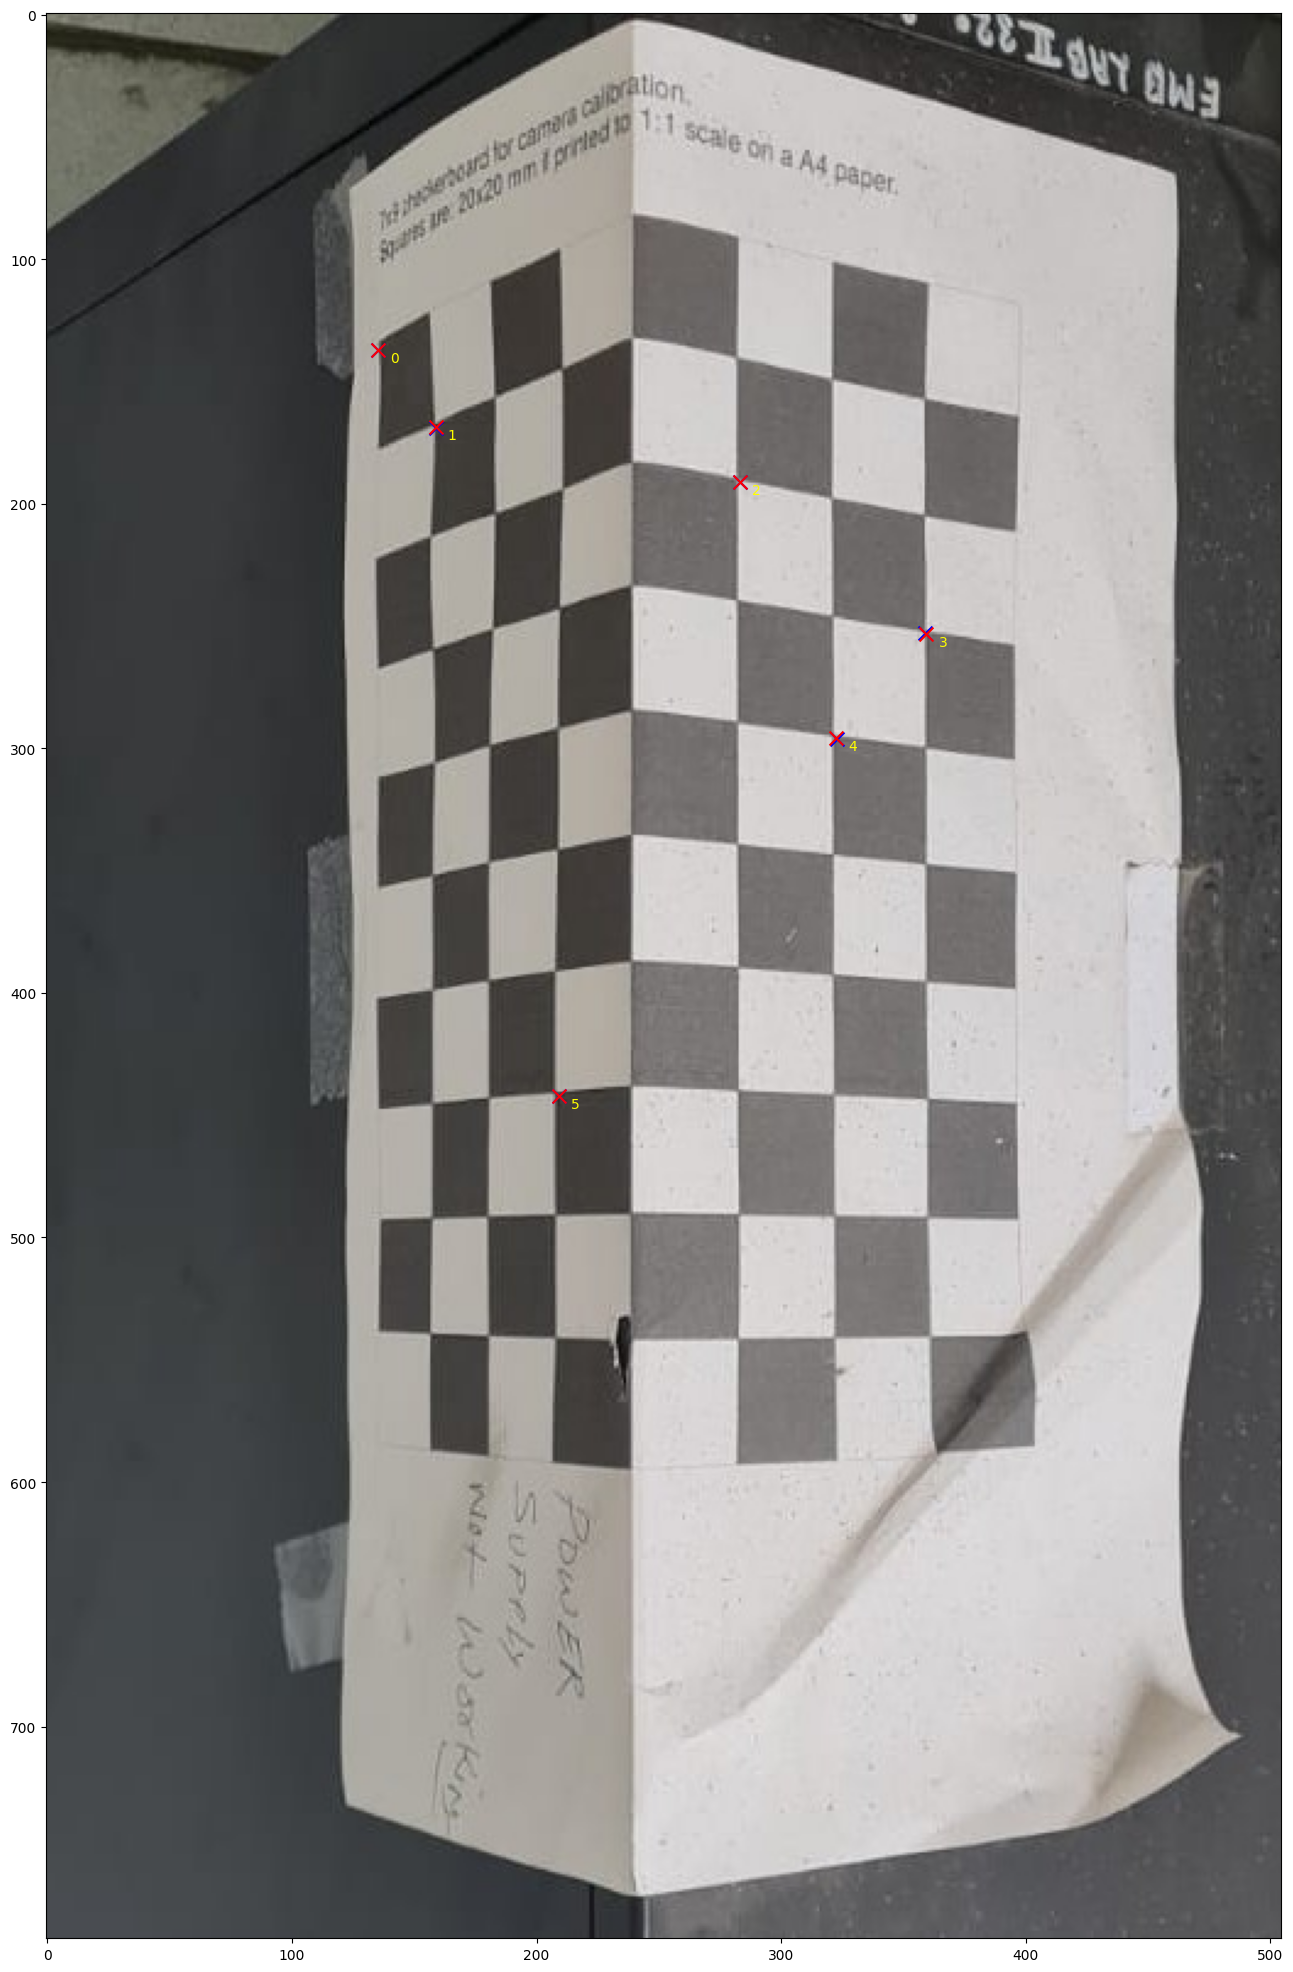

In [85]:

plt.figure( figsize=(25,25))
plt.imshow(img)
for i in range(points_2d.shape[0]):
    plt.scatter(points_2d[i][0], points_2d[i][1], s=100,c='blue',marker='x')
    plt.scatter(pred[i][0], pred[i][1], s=100,c='red',marker='x')
    plt.annotate(str(i), xy=(pred[i][0]+5, pred[i][1]+5), xycoords='data',fontsize= 10, color='yellow')
plt.show()

# Un Normalized Points

In [87]:
points_3d_homo = make_homo(points_3d)
P_1 = np.hstack((points_3d_homo,np.zeros_like(points_3d_homo),-points_2d[:,0][:,np.newaxis]*points_3d_homo))
P_2 = np.hstack((np.zeros_like(points_3d_homo),points_3d_homo,-points_2d[:,1][:,np.newaxis]*points_3d_homo))
P = np.zeros((P_1.shape[0]*2,P_1.shape[1]))
P[0::2,:] = P_1
P[1::2,:] = P_2

u,w = np.linalg.eig(np.matmul(P.T,P))
P = w[:,np.argmin(u)].reshape(3,4)

pred = np.dot(P, points_3d_homo.T) 
pred = pred / pred[2, :] 
pred=pred[0:2, :].T
    
print('Calculated 2D Coordinates with help of Projection matrix: \n')
print(pred)
err = np.sqrt( np.mean(np.sum( (pred - points_2d)**2, 1)) )
print('\n\n RMSE error between Calcualted and actual 2D points: {}'.format(err))

Calculated 2D Coordinates with help of Projection matrix: 

[[135.12867962 137.17514451]
 [158.75705024 168.72366453]
 [283.23065081 191.14477798]
 [359.40591729 253.15092818]
 [322.26045687 295.69494942]
 [209.22163511 442.1131376 ]]


 RMSE error between Calcualted and actual 2D points: 0.43707945262627396
